# Assignment 1 - mkecera3@gatech.edu

## Import libraries

In [2]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import torch.nn.functional as F
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn import preprocessing
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm

/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Load and save the datasets

Start of citation - the following code was addapted from https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

In [17]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# transform = transforms.Compose([transforms.ToTensor()])

trainset = datasets.MNIST('./data', download=False, train=True, transform=transform)
testset = datasets.MNIST('./data', download=False, train=False, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

## Neural network

### MNIST dataset

In [ ]:
def nnPredict(model, valloader, criterion):
    correct_count, all_count = 0, 0
    running_loss = 0
    for images,labels in valloader:
        images = images.view(images.shape[0], -1)
        with torch.no_grad():
                output = model(images)
                loss = criterion(output, labels)
                running_loss += loss.item()
        
#         print(images.shape)
#         print(labels.shape)

        for i in range(len(labels)):
            img = images[i].view(1, 784)
#             print(img.shape)
            with torch.no_grad():
                logps = model(img)

            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1

#     print("Number Of Images Tested =", all_count)
#     print("Model Accuracy =", (correct_count/all_count))
#     print("Testing Loss  =", (running_loss/len(valloader)))
    
    return running_loss/len(valloader), correct_count, all_count

In [ ]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10
drop_out = 0.2

model = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[1], output_size),
    nn.LogSoftmax(dim=1)
    )

In [ ]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [ ]:
def trainNN(model):
    optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
    time0 = time()
    epochs = 30
    lossData = []
    accData = []
    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)
        
            # Training pass
            optimizer.zero_grad()
            
            output = model(images)
            loss = criterion(output, labels)
            
            #This is where the model learns by backpropagating
            loss.backward()
            
            #And optimizes its weights here
            optimizer.step()
            
            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
            
        testingLoss, correctCount, allCount = nnPredict(model, valloader, criterion)
        print("Testing Loss  =", (testingLoss))
        
        lossData.append([e, running_loss/len(trainloader), 'Training Error'])
        lossData.append([e, testingLoss, 'Testing Error'])
        accData.append([e, correctCount / allCount])
    
    return lossData, accData    
    print("\nTraining Time (in minutes) =",(time()-time0)/60)

In [ ]:
lossDataBaseline, accDataBaseline = trainNN(model)

In [ ]:
accDataBaseline = [[row[0], row[1], 'Baseline Accuracy'] for row in accDataBaseline]

In [ ]:
lossDataBaseline = pd.DataFrame.from_records(lossDataBaseline, columns=["Epoch", "Loss", "Stage"])
accDataBaseline = pd.DataFrame.from_records(accDataBaseline, columns=["Epoch", "Accuracy", "Stage"])

In [ ]:
# vizualize train and test error across iterations
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataBaseline
    ).set_title('Baseline NN')

In [ ]:
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataBaseline
    ).set_title('3 hidden NN')

In [ ]:
testingLoss, correctCount, allCount = nnPredict(model, testloader, criterion)

In [ ]:
correctCount / allCount

In [ ]:
input_size = 784
hidden_sizes = [256, 128, 64]
output_size = 10
drop_out = 0.2

model_complex = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[1], hidden_sizes[2]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[2], output_size),
    nn.LogSoftmax(dim=1)
    )

In [ ]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model_complex(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [ ]:
lossDataComplex, accDataComplex = trainNN(model_complex)

In [ ]:
accDataComplex = [[row[0], row[1], 'More nodes and layers Accuracy'] for row in accDataComplex]

In [ ]:
lossDataComplex = pd.DataFrame.from_records(lossDataComplex, columns=["Epoch", "Loss", "Stage"])
accDataComplex = pd.DataFrame.from_records(accDataComplex, columns=["Epoch", "Accuracy", "Stage"])

In [ ]:
# vizualize train and test error across iterations
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataComplex
    ).set_title('3 hidden NN')

In [ ]:
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataComplex
    ).set_title('3 hidden NN')

End of citation - the preceding code was addapted from https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627





In [ ]:
testingLoss, correctCount, allCount = nnPredict(model_complex, testloader, criterion)

In [ ]:
correctCount / allCount

In [ ]:
input_size = 784
hidden_sizes = [256, 128, 64]
output_size = 10
drop_out = 0.2

model_dropout = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[1], hidden_sizes[2]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[2], output_size),
    nn.LogSoftmax(dim=1)
    )

In [ ]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model_dropout(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [ ]:
lossDataDropout, accDataDropout = trainNN(model_dropout)

In [ ]:
accDataDropout = [[row[0], row[1], 'Dropout Accuracy'] for row in accDataDropout]

In [ ]:
lossDataDropout = pd.DataFrame.from_records(lossDataDropout, columns=["Epoch", "Loss", "Stage"])
accDataDropout = pd.DataFrame.from_records(accDataDropout, columns=["Epoch", "Accuracy", "Stage"])

In [ ]:
# vizualize train and test error across iterations
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataDropout
    ).set_title('Dropout NN')

In [ ]:
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataDropout
    ).set_title('Dropout NN')

In [ ]:
accData = accDataBaseline.copy()
accData = accData.append(accDataComplex)
accData = accData.append(accDataDropout)

In [ ]:
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accData
    ).set_title('Accuracy of NN versions')

In [ ]:
testingLoss, correctCount, allCount = nnPredict(model_complex, testloader, criterion)

In [ ]:
correctCount / allCount

### Credit default dataset

In [3]:
# load dataset
creditDataDf = pd.read_excel('./data/default of credit card clients.xls', header=1)
creditDataDf = creditDataDf.drop(columns=['ID'])

In [4]:
# create dummy variables from categorical
creditDataDf = pd.get_dummies(creditDataDf, prefix=['SEX', 'EDUCATION', 'MARRIAGE'], columns=['SEX', 'EDUCATION', 'MARRIAGE'])

In [5]:
# drop last mummy variable
creditDataDf = creditDataDf.drop(columns=['SEX_2', 'EDUCATION_6', 'MARRIAGE_3'])

In [6]:
y = creditDataDf['default payment next month']
creditDataDf = creditDataDf.drop(columns=['default payment next month'])

In [7]:
# normalize the data
x = creditDataDf.values #returns a numpy array
min_max_scaler = preprocessing.StandardScaler()
x_scaled = min_max_scaler.fit_transform(x)
creditDataDf = pd.DataFrame(x_scaled, columns=creditDataDf.columns)

In [8]:
creditDataDf

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,SEX_1,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2
0,-1.136720,-1.246020,1.794564,1.782348,-0.696663,-0.666599,-1.530046,-1.486041,-0.642501,-0.647399,...,-0.810161,-0.021608,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.042465,1.093780,-1.066471
1,-0.365981,-1.029047,-0.874991,1.782348,0.138865,0.188746,0.234917,1.992316,-0.659219,-0.666747,...,-0.810161,-0.021608,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.042465,-0.914261,0.937672
2,-0.597202,-0.161156,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,-0.298560,-0.493899,...,-0.810161,-0.021608,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.042465,-0.914261,0.937672
3,-0.905498,0.164303,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,-0.057491,-0.013293,...,-0.810161,-0.021608,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.042465,1.093780,-1.066471
4,-0.905498,2.334029,-0.874991,0.111736,-0.696663,0.188746,0.234917,0.253137,-0.578618,-0.611318,...,1.234323,-0.021608,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.042465,1.093780,-1.066471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.404759,0.381275,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,1.870379,2.018136,...,1.234323,-0.021608,-0.738375,-0.937295,2.258602,-0.064163,-0.097063,-0.042465,1.093780,-1.066471
29996,-0.134759,0.815221,-0.874991,-0.723570,-0.696663,-0.666599,0.234917,0.253137,-0.672786,-0.665299,...,1.234323,-0.021608,-0.738375,-0.937295,2.258602,-0.064163,-0.097063,-0.042465,-0.914261,0.937672
29997,-1.059646,0.164303,3.574267,2.617654,1.809921,-0.666599,0.234917,0.253137,-0.647227,-0.643830,...,1.234323,-0.021608,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.042465,-0.914261,0.937672
29998,-0.674276,0.598248,0.904712,-0.723570,0.138865,0.188746,0.234917,-0.616452,-0.717982,0.410269,...,1.234323,-0.021608,-0.738375,-0.937295,2.258602,-0.064163,-0.097063,-0.042465,1.093780,-1.066471


In [9]:
X_train, X_test, y_train, y_test = train_test_split(creditDataDf, y, test_size=0.2, random_state=37)

In [10]:
print(X_train.columns)
print(len(X_train.columns))

Index(['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX_1', 'EDUCATION_0',
       'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4',
       'EDUCATION_5', 'MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2'],
      dtype='object')
30


In [11]:
sum(y_train)/len(y_train)

0.22145833333333334

In [12]:
# convert data to tensors
X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
X_test_tensor = torch.tensor(X_test.values.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.int))
y_test_tensor = torch.tensor(y_test.values.astype(np.int))

In [13]:
trainTorchDataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
valTorchDataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

In [14]:
len(valTorchDataset)

6000

In [15]:
trainloader2 = torch.utils.data.DataLoader(trainTorchDataset, batch_size=64, shuffle=True)
valloader2 = torch.utils.data.DataLoader(valTorchDataset, batch_size=len(valTorchDataset), shuffle=True)

In [ ]:
def nnPredictTabular(model2, valloader2, criterion):
    correct_count, all_count = 0, 0
    running_loss = 0
    probList = []
    for rows,labels in valloader2:
        
#         print(rows.shape)
#         print(labels.shape)
        
        with torch.no_grad():
                output = model2(rows)
                loss = criterion(output, labels)
                running_loss += loss.item()


        for i in range(len(labels)):
            row = rows[i].view(1, 30)
#             print(row.shape)
            with torch.no_grad():
                logps = model2(row)

            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            probList.append(probab)
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1

#     print("Number Of Images Tested =", all_count)
#     print("Model Accuracy =", (correct_count/all_count))
#     print("Testing Loss  =", (running_loss/len(valloader2)))
    
    return running_loss/len(valloader2), correct_count, all_count, probList

In [ ]:
input_size = 30
hidden_sizes = [25, 15]
output_size = 2

modelTabBaseline = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[1], output_size),
    nn.LogSoftmax(dim=1)
    )
criterion = nn.NLLLoss()

In [ ]:
def trainTabNN(model):
    # optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    optimizer = optim.Adam(model.parameters(), lr=0.01, momentum=0.5)
    time0 = time()
    epochs = 50
    lossData = []
    accData=[]
    for e in range(epochs):
        running_loss = 0
        for rows, labels in trainloader2:
                
            # Training pass
            optimizer.zero_grad()
            
            output = model(rows)
            loss = criterion(output, labels)
            
            #This is where the model learns by backpropagating
            loss.backward()
            
            #And optimizes its weights here
            optimizer.step()
            
            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader2)))
            
        testingLoss, correctCount, allCount, proba = nnPredictTabular(model, valloader2, criterion)
        print("Testing Loss  =", (testingLoss))
        print("Testing Accuracy  =", (correctCount / allCount))
        
        lossData.append([e, running_loss/len(trainloader2), 'Training Loss'])
        lossData.append([e, testingLoss, 'Testing Loss'])
        accData.append([e, correctCount / allCount])
    
    return lossData, accData
        
    print("\nTraining Time (in minutes) =",(time()-time0)/60)

In [ ]:
lossDataBaseline, accDataBaseline = trainTabNN(modelTabBaseline)

In [ ]:
testingLoss, correctCount, allCount, proba = nnPredictTabular(modelTabBaseline, valloader2, criterion)

In [ ]:
proba = [row[1] for row in proba]

In [ ]:
roc_auc_score(y_test, proba)

In [ ]:
accDataBaseline = [[row[0], row[1], 'Baseline Accuracy'] for row in accDataBaseline]
lossDataBaseline = pd.DataFrame.from_records(lossDataBaseline, columns=["Epoch", "Loss", "Stage"])
accDataBaseline = pd.DataFrame.from_records(accDataBaseline, columns=["Epoch", "Accuracy", "Stage"])

In [ ]:
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataBaseline
    ).set_title('Baseline NN')

In [ ]:
sns.set(
    style="darkgrid"
    )
    
sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataBaseline
    ).set_title('Baseline NN')

In [ ]:
input_size = 30
hidden_sizes = [25, 20, 20, 20, 15, 15]
output_size = 2

modelTabLarge = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[1], hidden_sizes[2]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[2], hidden_sizes[3]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[3], hidden_sizes[4]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[4], hidden_sizes[5]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[5], output_size),
    nn.LogSoftmax(dim=1)
    )
criterion = nn.NLLLoss()

In [ ]:
lossDataLarge, accDataLarge = trainTabNN(modelTabLarge)

In [ ]:
accDataLarge = [[row[0], row[1], '5 hidden Accuracy'] for row in accDataLarge]
lossDataLarge = pd.DataFrame.from_records(lossDataLarge, columns=["Epoch", "Loss", "Stage"])
accDataLarge = pd.DataFrame.from_records(accDataLarge, columns=["Epoch", "Accuracy", "Stage"])

In [ ]:
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataLarge
    ).set_title('Baseline NN')

In [ ]:
sns.set(
    style="darkgrid"
    )
    
sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataLarge
    ).set_title('Baseline NN')

In [ ]:
testingLoss, correctCount, allCount, proba = nnPredictTabular(modelTabLarge, valloader2, criterion)
proba = [row[1] for row in proba]
roc_auc_score(y_test, proba)

## Decision tree

### MNIST dataset

In [18]:
trainset = datasets.MNIST('./data', download=False, train=True, transform=transform)
testset = datasets.MNIST('./data', download=False, train=False, transform=transform)

In [34]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset))
valloader = torch.utils.data.DataLoader(valset, batch_size=len(valset))
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset))

In [35]:
X_train_MNIST = trainset.data.numpy()
X_test_MNIST = testset.data.numpy()

In [36]:
y_train_MNIST = trainset.targets.numpy()
y_test_MNIST = testset.targets.numpy()

In [37]:
np.bincount(y_train_MNIST) + np.bincount(y_test_MNIST)

array([6903, 7877, 6990, 7141, 6824, 6313, 6876, 7293, 6825, 6958])

In [38]:
print(X_train_MNIST.shape)
print(y_train_MNIST.shape)

(60000, 28, 28)
(60000,)


In [39]:
X_train_MNIST_reshaped = X_train_MNIST.reshape((60000, 784))
X_test_MNIST_reshaped = X_test_MNIST.reshape((10000, 784))

In [40]:
param_grid = {'max_depth': np.arange(3, 30, 3), 'min_samples_leaf': np.arange(5, 50, 5) }
gridSearchTree = GridSearchCV(
    tree.DecisionTreeClassifier(), param_grid, n_jobs=-1, verbose=3, scoring='accuracy'
    )
gridSearchTree.fit(X_train_MNIST_reshaped, y_train_MNIST)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   18.3s


KeyboardInterrupt: 

In [0]:
gridSearchTree.best_params_

In [0]:
preds = gridSearchTree.predict(X_test_MNIST_reshaped)
print(accuracy_score(preds, y_test_MNIST))

In [0]:
cvResultsScore = pd.DataFrame(gridSearchTree.cv_results_)
cvResultsScore = cvResultsScore[['param_max_depth', 'param_min_samples_leaf', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_test_score')
sns.set_context("paper")
sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis').set_title('Accuracy')

In [0]:
cvResultsTimeTrain = pd.DataFrame(gridSearchTree.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_max_depth', 'param_min_samples_leaf', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_fit_time')
sns.set_context("paper")
sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')

In [0]:
cvResultsTimeScore = pd.DataFrame(gridSearchTree.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_max_depth', 'param_min_samples_leaf', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 3)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_score_time')
sns.set_context("paper")
sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis').set_title('Score time')

### Credit default dataset

In [19]:
np.bincount(y_train) + np.bincount(y_test)

array([23364,  6636])

In [20]:
param_grid = {'max_depth': np.arange(3, 30, 3), 'min_samples_leaf': np.arange(5, 50, 5) }
gridSearchTree = GridSearchCV(
    tree.DecisionTreeClassifier(), param_grid, n_jobs=-1, verbose=2, scoring='roc_auc'
    )
gridSearchTree.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:   21.8s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': array([ 3,  6,  9, 12, 15, 18, 21, 24, 

In [21]:
preds = gridSearchTree.predict(X_test)
probs = gridSearchTree.predict_proba(X_test)
print(accuracy_score(preds, y_test))
probs = [row[1] for row in probs]
print(roc_auc_score(y_test, probs))
print(gridSearchTree.best_params_)

0.8148333333333333
0.7560852612029947
{'max_depth': 6, 'min_samples_leaf': 45}


Text(0.5, 1, 'ROC_AUC')

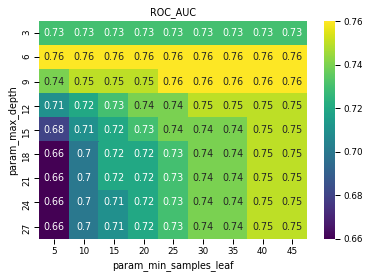

In [29]:
cvResultsScore = pd.DataFrame(gridSearchTree.cv_results_)
cvResultsScore = cvResultsScore[['param_max_depth', 'param_min_samples_leaf', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_test_score')
sns.set_context("paper")
sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis').set_title('ROC_AUC')

Text(0.5, 1, 'Training time')

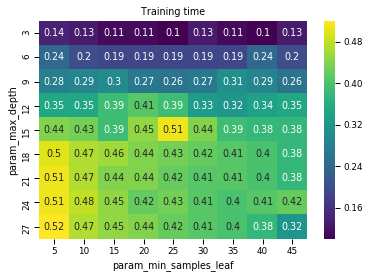

In [30]:
cvResultsTimeTrain = pd.DataFrame(gridSearchTree.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_max_depth', 'param_min_samples_leaf', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_fit_time')
sns.set_context("paper")
sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')

Text(0.5, 1, 'Score time')

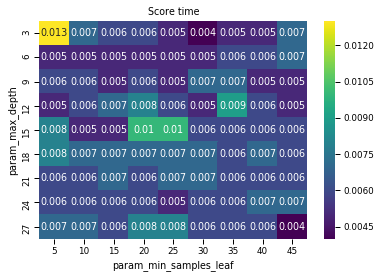

In [33]:
cvResultsTimeScore = pd.DataFrame(gridSearchTree.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_max_depth', 'param_min_samples_leaf', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 3)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_score_time')
sns.set_context("paper")
sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis').set_title('Score time')

## Boosting

### MNIST

In [ ]:
param_grid = {'max_depth': np.arange(3, 30, 3), 'n_estimators': np.arange(10, 100, 10) }
gridSearchBoosting = GridSearchCV(
    GradientBoostingClassifier(), param_grid, n_jobs=-1, verbose=3, scoring='accuracy'
    )
gridSearchBoosting.fit(X_train_MNIST_reshaped, y_train_MNIST)

In [ ]:
gridSearchBoosting.best_params_

In [ ]:
preds = gridSearchBoosting.predict(X_test_MNIST_reshaped)
print(accuracy_score(preds, y_test_MNIST))

In [ ]:
cvResultsScore = pd.DataFrame(gridSearchBoosting.cv_results_)
cvResultsScore = cvResults[['param_max_depth', 'param_n_estimators', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')
sns.set_context("paper")
sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')

In [ ]:
cvResultsTimeTrain = pd.DataFrame(gridSearchBoosting.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_max_depth', 'param_n_estimators', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_fit_time')
sns.set_context("paper")
sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')

In [ ]:
cvResultsTimeScore = pd.DataFrame(gridSearchBoosting.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_max_depth', 'param_n_estimators', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 3)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_score_time')
sns.set_context("paper")
sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis').set_title('Score time')

### Credit default

In [ ]:
param_grid = {'max_depth': np.arange(3, 30, 3), 'n_estimators': np.arange(10, 100, 10) }
gridSearchBoosting = GridSearchCV(
    GradientBoostingClassifier(), param_grid, n_jobs=-1, verbose=3, scoring='roc_auc'
    )
gridSearchBoosting.fit(X_train, y_train)


In [ ]:
preds = gridSearchBoosting.predict(X_test)
probs = gridSearchBoosting.predict_proba(X_test)
print(accuracy_score(preds, y_test))
probs = [row[1] for row in probs]
print(roc_auc_score(y_test, probs))
print(gridSearchBoosting.best_params_)

In [ ]:
cvResultsScore = pd.DataFrame(gridSearchBoosting.cv_results_)
cvResultsScore = cvResults[['param_max_depth', 'param_n_estimators', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')
sns.set_context("paper")
sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('ROC_AUC')

In [ ]:
cvResultsTimeTrain = pd.DataFrame(gridSearchBoosting.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_max_depth', 'param_n_estimators', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_fit_time')
sns.set_context("paper")
sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')

In [ ]:
cvResultsTimeScore = pd.DataFrame(gridSearchBoosting.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_max_depth', 'param_n_estimators', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 3)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_score_time')
sns.set_context("paper")
sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis').set_title('Score time')

## KNN

### MNIST

In [ ]:
param_grid = {'n_neighbors': np.arange(3, 24, 3), 'weights': ['uniform', 'distance']}
kNN = GridSearchCV(
    KNeighborsClassifier(), param_grid, n_jobs=-1, verbose=3, scoring='accuracy'
    )
kNN.fit(X_train_MNIST_reshaped, y_train_MNIST)

preds = kNN.predict(X_test_MNIST_reshaped)
print(accuracy_score(preds, y_test_MNIST))

In [ ]:
cvResultsScore = pd.DataFrame(kNN.cv_results_)
cvResultsScore = cvResults[['param_n_neighbors', 'param_weights', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')
sns.set_context("paper")
sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')

In [ ]:
cvResultsTimeTrain = pd.DataFrame(kNN.cv_results_)
cvResultsTimeTrain = cvResults[['param_n_neighbors', 'param_weights', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_fit_time')
sns.set_context("paper")
sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')

In [ ]:
cvResultsTimeScore = pd.DataFrame(kNN.cv_results_)
cvResultsTimeScore = cvResults[['param_n_neighbors', 'param_weights', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 2)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_score_time')
sns.set_context("paper")
sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')

### Credit default

In [ ]:
param_grid = {'n_neighbors': np.arange(3, 24, 3), 'weights': ['uniform', 'distance']}
kNN = GridSearchCV(
    KNeighborsClassifier(), param_grid, n_jobs=-1, verbose=3, scoring='roc_auc'
    )
kNN.fit(X_train, y_train)

In [ ]:
preds = kNN.predict(X_test)
probs = kNN.predict_proba(X_test)
print(accuracy_score(preds, y_test))

In [ ]:
probs = kNN.predict_proba(X_test)
probs = [row[1] for row in probs]
roc_auc_score(y_test, probs)

In [ ]:
cvResultsScore = pd.DataFrame(kNN.cv_results_)
cvResultsScore = cvResults[['param_n_neighbors', 'param_weights', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')
sns.set_context("paper")
sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('ROC AUC')

In [ ]:
cvResultsTimeTrain = pd.DataFrame(kNN.cv_results_)
cvResultsTimeTrain = cvResults[['param_n_neighbors', 'param_weights', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_fit_time')
sns.set_context("paper")
sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')

In [ ]:
cvResultsTimeScore = pd.DataFrame(kNN.cv_results_)
cvResultsTimeScore = cvResults[['param_n_neighbors', 'param_weights', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 2)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_score_time')
sns.set_context("paper")
sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')

## SVM

### MNIST

In [ ]:
clf = svm.SVC()
clf.fit(X_train_MNIST_reshaped, y_train_MNIST)
preds = clf.predict(X_test_MNIST_reshaped)
print(accuracy_score(preds, y_test_MNIST))

In [ ]:
### Credit default

In [ ]:
clf = svm.SVC()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print(accuracy_score(preds, y_test))